# SYMBOLIC STUDY
## **DOUBLE WISHBONE BELL-CRANK PUSH-ROD**
------------------------------------

# SYMBOLIC STUDY

## **SYSTEM DESCRIPTION**
-------------------------

In [1]:
from IPython.display import display, Markdown
display(Markdown(filename='README.md'))

# Drive Shafts

**TEMPLATE-BASED TOPOLOGY**

------------------------------------------------

### **Summary**



--------------------------------------

### **Topology Layout**



------------------------------------------------------
<br/>

[^1]: The tool uses [euler-parameters](https://en.wikibooks.org/wiki/Multibody_Mechanics/Euler_Parameters) -which is a 4D unit quaternion- to represents bodies orientation in space. This makes the generalized coordinates used to fully define a body in space to be **7,** instead of **6**, it also adds an algebraic equation to the constraints that ensures the unity/normalization of the body quaternion. This is an important remark as the calculations of the degrees-of-freedom depends on it.



---------------------------------------------------------------
---------------------------------------------------------------

## **SYMBOLIC TOPOLOGY**
------------------------

In this section, we create the symbolic topology that captures the topological layout that we just discussed.</br>
Defining the topology is very simple. We start by importing the ```template_topology``` class and create a new instance that represents our symbolic model. Then we start adding the components we discussed earlier, starting by the bodies, then the joints, actuators and forces, and thats it.</br>
These components will be represented symbolically, and therefore there is no need for any numerical inputs at this step.

The system is stored in a form of a network graph that stores all the data needed for the assemblage of the system equations later. But even before the assemblage process, we can gain helpful insights about our system as well be shown.


In [1]:
import os
from uraeus.smbd.systems import template_topology, configuration

In [2]:
# Getting the database root directory which is three levels up from here
database_directory = os.path.abspath('../../../')

# Creating "data" directory to store generated system data
os.makedirs('data', exist_ok=True)

In [3]:
model_name = 'drive_shafts_v2'

In [4]:
sym_model = template_topology(model_name)

### Adding Bodies

In [5]:
# Adding Bodies
# =============

# Drive Shafts
# ============
sym_model.add_body('inner_shaft', mirror=True)
sym_model.add_body('coupling_inner', mirror=True)
sym_model.add_body('coupling_outer', mirror=True)

# Helper Bodies
# =============
sym_model.add_body('differential', virtual=True)
sym_model.add_body('wheel_hub', virtual=True, mirror=True)


### Adding Joints

In [6]:
# Adding Joints
# =============
sym_model.add_joint.revolute('diff_joint', 'rbr_inner_shaft', 'vbs_differential', mirror=True)
sym_model.add_joint.universal('inner_cv', 'rbr_inner_shaft', 'rbr_coupling_inner', mirror=True)
sym_model.add_joint.translational('coupling_trans', 'rbr_coupling_inner', 'rbr_coupling_outer', mirror=True)
sym_model.add_joint.universal('outer_cv', 'rbr_coupling_outer', 'vbr_wheel_hub', mirror=True)


### Adding Forces

In [12]:
# Adding Forces
# =============
sym_model.add_force.local_torque('drive', 'rbr_inner_shaft', mirror=True)



### **SYMBOLIC CHARACTERISTICS**

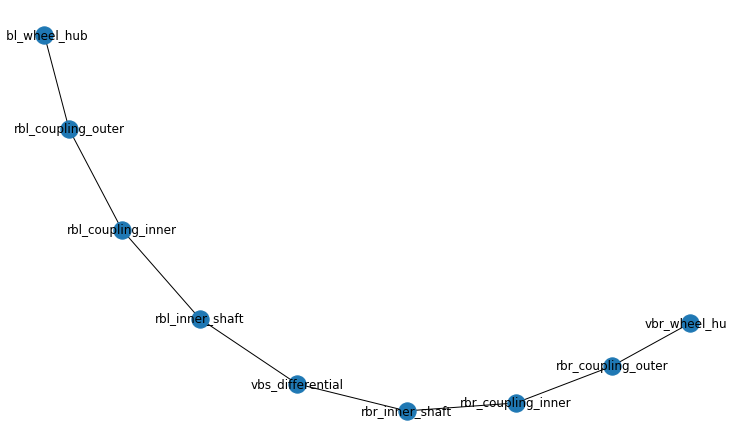

In [13]:
sym_model.topology.draw_constraints_topology()

### **ASSEMBLING**

This is the last step of the symbolic building process, where we make the system starts the assemblage process of the governing equations, which will be used then in the code generation for the numerical simulation, and also can be used for further symbolic manipulations.</br>

*Note: The equations' notations will be discussed in the tool documentation files.*

In [14]:
sym_model.save('data')
sym_model.assemble()

---------------------------------------------------------------
---------------------------------------------------------------

## **SYSTEM CONFIGURATION**
---------------------------

In this step we define a symbolic configuration of our symbolic topology. As you may have noticed in the symbolic topology building step, we only cared about the *'topology'*, thats is the system bodies and their connectivity, and we did not care explicitly with how these components are configured in space.</br>
In order to create a valid numerical simulation session, we have to provide the system with its numerical configuration needed, for example, the joints' locations and orientations. The symbolic topology in its raw form will require you to manually enter all these numerical arguments, which can be cumbersome even for smaller systems. This can be checked by checking the configuration inputs of the symbolic configuration as ```config._config.input_nodes```

Here we start by stating the symbolic inputs we wish to use instead of the default inputs set, and then we define the relation between these newly defined arguments and the original ones. The details of this process will be provided in the documentation.

In [15]:
config_name = '%s_cfg'%model_name
sym_config = configuration(config_name, sym_model)

### CONFIGURATION INPUTS

In [16]:
# Adding UserInputs
# =================

sym_config.add_point.UserInput('inner_cv', mirror=True)
sym_config.add_point.UserInput('outer_cv', mirror=True)
sym_config.add_point.UserInput('diff_input', mirror=True)

sym_config.add_vector.UserInput('x')
sym_config.add_vector.UserInput('y')
sym_config.add_vector.UserInput('z')


### CONFIGURATION RELATIONS

In [17]:
# Defining Relations
# ==================
sym_config.add_point.Centered('coupling_mid', ('hpr_inner_cv', 'hpr_outer_cv'), mirror=True)

# Inner CV Joint:
# ===============
sym_config.add_relation.Equal_to('pt1_jcr_inner_cv', ('hpr_inner_cv',), mirror=True)
sym_config.add_relation.Oriented('ax1_jcr_inner_cv', ('hpr_inner_cv', 'hpr_diff_input'), mirror=True)
sym_config.add_relation.Oriented('ax2_jcr_inner_cv', ('hpr_outer_cv', 'hpr_inner_cv'), mirror=True)

# Outer CV Joint:
# ===============
sym_config.add_relation.Equal_to('pt1_jcr_outer_cv', ('hpr_outer_cv',), mirror=True)
sym_config.add_relation.Oriented('ax1_jcr_outer_cv', ('hpr_outer_cv', 'hpr_inner_cv'), mirror=True)
sym_config.add_relation.Equal_to('ax2_jcr_outer_cv', ('vcs_y',), mirror=True)

# Coupling Trans Joint:
# ====================
sym_config.add_relation.Equal_to('pt1_jcr_coupling_trans', ('hpr_coupling_mid',), mirror=True)
sym_config.add_relation.Oriented('ax1_jcr_coupling_trans', ('hpr_outer_cv', 'hpr_inner_cv'), mirror=True)

# Differential Joint:
# ===================
sym_config.add_relation.Equal_to('pt1_jcr_diff_joint', ('hpr_diff_input',), mirror=True)
sym_config.add_relation.Equal_to('ax1_jcr_diff_joint', ('vcs_y',), mirror=True)

# Drive Torque:
# =============
sym_config.add_relation.Equal_to('ax1_far_drive', ('vcs_y',), mirror=True)


### GEOMETRIES

Here we start defining basic geometric shapes that can represents the shapes of the bodies in our system. This serves two points:
- Visualization and Animation in blender.
- Evaluating the bodies inertia properties from these basic geometries instead of explicit definition.

In [18]:
# ===================
# Creating Geometries
# ===================
sym_config.add_scalar.UserInput('shafts_radius')

sym_config.add_geometry.Cylinder_Geometry('inner_shaft', ('hpr_diff_input', 'hpr_inner_cv','s_shafts_radius'), mirror=True)
sym_config.assign_geometry_to_body('rbr_inner_shaft', 'gmr_inner_shaft', mirror=True)

sym_config.add_geometry.Cylinder_Geometry('coupling_inner', ('hpr_inner_cv', 'hpr_coupling_mid','s_shafts_radius'), mirror=True)
sym_config.assign_geometry_to_body('rbr_coupling_inner', 'gmr_coupling_inner', mirror=True)

sym_config.add_geometry.Cylinder_Geometry('coupling_outer', ('hpr_coupling_mid', 'hpr_outer_cv','s_shafts_radius'), mirror=True)
sym_config.assign_geometry_to_body('rbr_coupling_outer', 'gmr_coupling_outer', mirror=True)


### ASSEMBLING

In [19]:
sym_config.export_JSON_file('data')

## CODE GENERATION

In [20]:
from uraeus.nmbd.python import templatebased_project

In [21]:
project = templatebased_project(database_directory)
project.create_dirs()

In [22]:
project.write_topology_code(sym_model)

File full path : C:\khaledghobashy\github\uraeus_fsae\numenv\python\templates\drive_shafts_v2.py
